In [790]:
# !pip install pysd
import pysd
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn import metrics
import xgboost
pd.set_option('display.max_columns', 500)

* initial_time = 0
* final_time = 100
* time_step = 0.1 (дельта, которая даёт 1001 итерацию для подсчёта значений переменных в системе разностных уравнений)
* saveper = 1 (101 подглядывание в систему, чтобы следить за сходимостью)

* $fruitfulness = {eff}^1_w={eff}^2_w=0.015$
* $market efficiency = {eff}^1_m={eff}^2_m=0.011$
* sociability = 50

* p11, p13 - доли довольных и недовольных наших клиентов соотв.
* p21, p23 - доли довольных и недовольных клиентов у конкурента

In [9]:
# modified.doc

In [667]:
modified = pysd.load('main.py')

In [555]:
res = modified.run(return_columns=[
    "Customers", "Potential Customers", "Competitor customers", "total market",
    "market share", "competitor share", "proportion", 
]);

In [556]:
round(res['market share'].tail(int(res.shape[0] * 0.1)).diff().min(), 4)

0.0

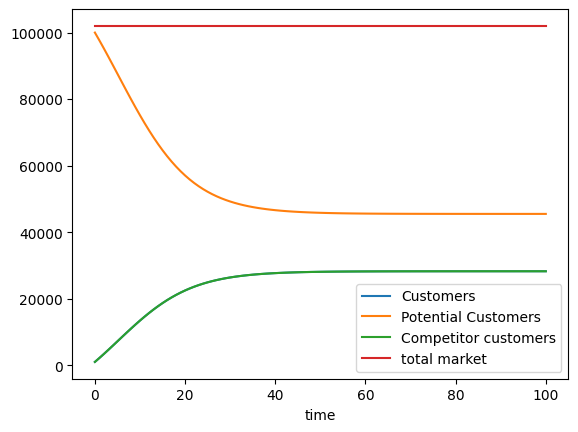

In [557]:
res.iloc[:, :4].plot();

Как будем проверять сходимость? 

Возьмем доли рынка (нашу и конкурента) и если они не будут в последние 5-10% шагов меняться более чем на 0.01% (0.0001 в абсолютном выражении), будем считать что модель сошлась. 
Не ищем в этом глубокого смысла, просто фактически смотрим, что данные выше порога хоть насколько то значимых изменений не колеблются. 


Тк скорость сходимости чувствительна к параметрам модели, интервалы времени для модели задаем методом пристального взгляда после их изменения 

Неиронично предполагаю, что это даст лучший результат по (качество модели / скорость решения дз) 

In [656]:
(res[['market share', 'competitor share']].tail(10).diff().abs().max() < 0.0001).all()

True

In [855]:
def generate_parameters(p11=None, p13=None, p21=None, p23=None, constraint=1.0):

    p11 = np.random.uniform() if not p11 else p11
    p13 = np.random.uniform(0, constraint - p11) if not p13 else p13
    p21 = np.random.uniform() if not p21 else p21
    p23 = np.random.uniform(0, constraint - p21) if not p23 else p23

    return {'p11': p11, 'p13': p13, 'p21': p21, 'p23': p23}


def play_bass(model, params, return_columns=['market share', 'competitor share'], check_share=0.1):

    res = model.run(params=params, return_columns=return_columns)

    if (res[return_columns].tail(int(res.shape[0] * check_share)).diff().abs().max() < 0.0001).all():
        res_dict = dict(params.items())
        for key in return_columns:
            res_dict[key] = res[key].iloc[-1]
        return res_dict

In [614]:
play_bass(modified, generate_parameters(), check_share=0.05)

{'p11': 0.2901427662899031,
 'p13': 0.5006172557687537,
 'p21': 0.5996035825550449,
 'p23': 0.3941918001185928,
 'market share': 0.022257822101655136,
 'competitor share': 0.6239365308310605}

In [670]:
from tqdm import tqdm

df_list = []
N = 10000
with tqdm(total=10000) as pbar:
    for i in range(N):
        tmp = play_bass(modified, generate_parameters(), check_share=0.1)
        if tmp:
            df_list.append(tmp)
        if (i > 0) & (i % 100==0):
            pbar.update(100)
            


 99%|█████████████████████████████████████▌| 9900/10000 [03:54<00:02, 42.29it/s]


In [680]:
df = pd.DataFrame(df_list)
df.shape

(9290, 6)

Модель сходится по нашему критерию (причем с долей проверки 10%) примерно в 93% случаев. 

При том, что кол-во итераций выбрано относительно небольшое, для ускорения расчетов, можно +/- смело утвержать, что можедель сходится 

In [681]:
df.head()

,p11,p13,p21,p23,market share,competitor share
0,0.163842,0.539732,0.008986,0.383098,0.078868,0.059494
1,0.044160,0.918742,0.436147,0.535084,0.017863,0.353021
2,0.786306,0.198492,0.173165,0.061970,0.854706,0.008709
3,0.600743,0.150267,0.733380,0.108899,0.015457,0.903524
4,0.527909,0.448862,0.521696,0.051749,0.004610,0.940603


In [673]:
df.to_csv('data.csv')

# ML 

In [682]:
from sklearn.model_selection import train_test_split
y = df['market share'].copy()
X = df.drop(columns=['market share', 'competitor share']).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1602)

In [748]:
def calc_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print("Train RMSE = %.4f" % metrics.mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test RMSE = %.4f" % metrics.mean_squared_error(y_test, y_test_pred, squared=False))
    print("Test MAPE = %.4f" % metrics.mean_absolute_percentage_error(y_test, y_test_pred))
    print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_test), y_test_pred))

In [811]:
cat = CatBoostRegressor(n_estimators=500, max_depth=12, learning_rate=0.1, verbose=False)
cat.fit(X_train, y_train)

In [812]:
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)

calc_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train RMSE = 0.0059
Test RMSE = 0.0256
Test MAPE = 12.5748
Test R^2 = 0.9960


In [805]:
bst = xgboost.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.02)

bst.fit(X_train, y_train)

y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)
calc_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train RMSE = 0.0149
Test RMSE = 0.0493
Test MAPE = 4.2191
Test R^2 = 0.9854


Конечно возможно что катбуст и XGBRegressor здесь это из пушки по воробьям, но времени мало, поэтому нужно +/- гарантированно и быстро получать результат 

XGBRegressor укладывается в +-7% судя по MAPE, так что пойдет 

# Линия уровня ~~моей ответственности~~

In [650]:
# np.random.randint(1, 8000)

Берем почти случайную точку (почти, потому что я рандом прогонял несколько раз, чтобы найти не граничный случай)

In [813]:
ex = df.iloc[5819].to_dict()
ex

{'p11': 0.3656507154718053,
 'p13': 0.4053335507280952,
 'p21': 0.23872516973257984,
 'p23': 0.2743305235085805,
 'market share': 0.29617857359254035,
 'competitor share': 0.1753491811977304}

Модель действительно сходится, проверили на всякий случай

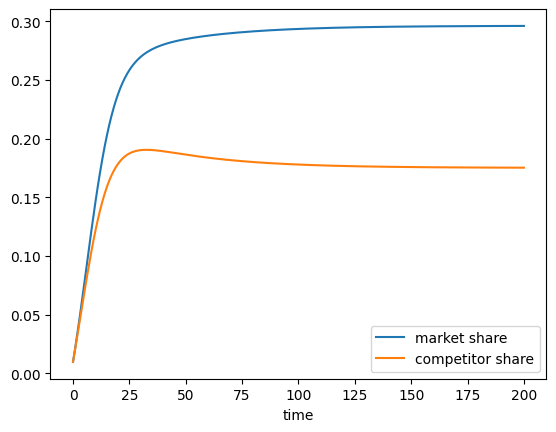

In [814]:
modified.run(params={'p11': ex['p11'], 'p13': ex['p13'], 'p21': ex['p21'], 'p23': ex['p23'],}
             , return_columns=['market share', 'competitor share']).plot();

Идея такая

Сначала просто насыпем много точек рядом, поищем среди них похожие. А потом, если останется время, попробуем решить бинарным поиском

In [925]:
def cacl_market_share_bst(p11, p13):
    """ для двух точек """
    return bst.predict(
        pd.DataFrame(
            {'p11': p11, 'p13': p13, 'p21': fixed_p21, 'p23': fixed_p23},
            index=[0]
        )
    )[0]

def draw_lvl(x, y, s=20):
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, s=s);
    plt.plot((0, 1), (1, 0))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('p11')
    plt.ylabel('p13')

In [914]:
p11_values = np.linspace(0, 1, 1000)

net_list = [0]*len(p11_values)

for i in range(len(net_list)):
    net_list[i] = generate_parameters(p11=p11_values[i], p21=ex['p21'], p23=ex['p23'])

net_df = pd.DataFrame(net_list)

net_df.loc[:, 'market_share'] = bst.predict(net_df)
net_df.loc[:, 'target_value'] = ex['market share']
net_df.loc[:, 'target_value'] = ex['market share']
net_df['diff_pc'] = ((net_df.market_share - net_df.target_value) / net_df.target_value).abs()

# не понял пока где косяк, но почему-то сгенерированные данные чуть за 1 все же выходят
r1 = net_df[(net_df.diff_pc < 0.07) & (net_df['p11'] + net_df['p13'] < 1.1)]

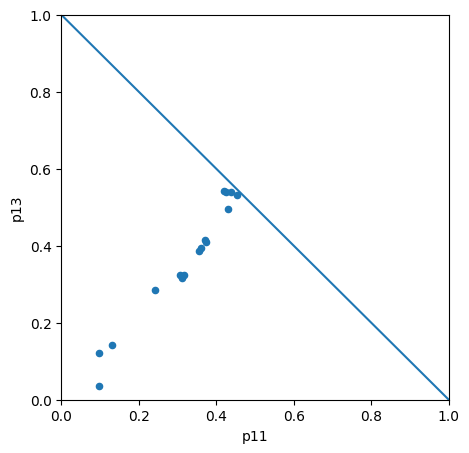

In [926]:
draw_lvl(r1.p11, r1.p13)

окей, легкие очертания мы получили

и они похожи на правду кстати говоря! что не может не радовать

сгенерируем сеточку поплотней

In [888]:
# Фиксированные значения
p21 = ex['p21']
p23 = ex['p23']
target_market_share = ex['market share']

ERR = 0.05

# Создаем сетку для p11 и p13
p11_values = np.linspace(0, 1, 200)
p13_values = np.linspace(0, 1, 200)

# Список для сохранения результатов
results = []

# Перебор значений
for p11 in tqdm(p11_values):
    for p13 in p13_values:
        if p11 + p13 <= 1:
            predicted_market_share = cacl_market_share_bst(p11, p13)
            # Проверяем, удовлетворяет ли разница в доле рынка нашим условиям
            if abs(predicted_market_share - target_market_share) / target_market_share <= ERR:  # 3% отклонение
                results.append((p11, p13, predicted_market_share))

100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 28.90it/s]


In [890]:
generated = pd.DataFrame(results, columns=['p11', 'p13', 'market share'])

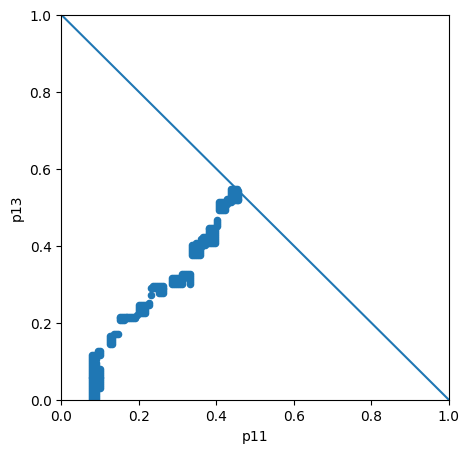

In [927]:
draw_lvl(generated.p11, generated.p13)

Так, теперь у нас побольше точек, можно попробавать сгладить их в какую-нибудь аналитическую функцию


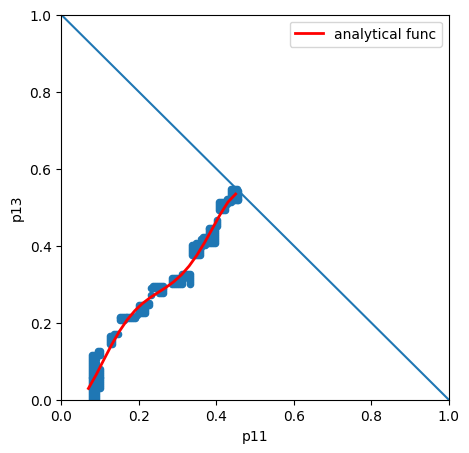

In [932]:
import numpy as np

def approximate_function(df, degree):
    x = df['p11']  # значения p11
    y = df['p13']  # значения p13
    coefficients = np.polyfit(x, y, degree)  # аппроксимация полиномом указанной степени
    return np.poly1d(coefficients)  # возвращаем объект полинома

polynomial_function = approximate_function(generated, 5)

draw_lvl(generated.p11, generated.p13);

x = np.linspace(0.07, 0.45, 20)
plt.plot(x, polynomial_function(x), color='red', lw=2, label='analytical func');
plt.legend();

In [928]:
[round(i, 2) for i in polynomial_function.coefficients]

[-610.39, 762.02, -338.79, 63.51, -3.3, 0.05]

В общем-то полином 5-й степени вот с такими коэф-ми и будет являться некоторым приближением нашей линии уровня

В рамках нее можем двигать p11 и p13 и сильно наша доля в рынке не должна поползти 